In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Before presenting our analysis, we first define some utility functions.

In [3]:
# Computes the FPR for a Bloom filter (assumes that filterSize is expressed in bytes).
def fpr(numElements, filterSize, numHash):
    return np.power(1 - np.exp(-numHash * numElements / (filterSize*8)), numHash)

# Generates a dataframe with statistics on the filters of a BF skip index.
# Each row of the dataframe describes one filter of the index.
# For each filter we report the number of blocks summarized, the estimated number of keys
# in all summarized blocks, the estimated FPR of the filter and its size (in bytes).
def skipProperties(filterSize, numHash, numEntries, avgKeys):
    data = []
    for j in range(0, numEntries):
        numBlocks = 1 << j
        numKeys = avgKeys * numBlocks
        estFpr = fpr(numKeys, filterSize, numHash)
        data.append([numBlocks, numKeys, estFpr, filterSize])
    return pd.DataFrame(data, columns = ['numBlocks', 'estKeys', 'estFpr', 'filterSize'])

# Returns the Hamming weight of an integer.
# Reference: https://en.wikipedia.org/wiki/Hamming_weight
def hamming(n):
    c = 0
    while n:
        c += 1
        n &= n - 1
    return c

# Lower bound for the index-based method.
def minNumVisited(d, numEntries):
    return 1 + np.floor(d / (1 << numEntries)) + hamming(d % (1 << numEntries))

fpRate = np.vectorize(fpr)
linearUpperBound = np.vectorize(lambda d: d+1)
skipLowerBound = np.vectorize(minNumVisited)

# Query analysis

In this notebook we analyze the results of our query simulations using BF skip indexes.<br>
We first import the result files, which describe query results for the `Birth` and `Transfer` events.

In [4]:
q_birth = pd.read_csv('data/queries_birth_res.csv')
q_birth = q_birth.sort_values(by=['distance'])
q_birth['skipLowerBound'] = skipLowerBound(q_birth['distance'], 7)
q_birth['skipDiff'] = q_birth['skipVisited']-q_birth['skipLowerBound']

q_transfer = pd.read_csv('data/queries_transfer_res.csv')
q_transfer = q_transfer.sort_values(by=['distance'])
q_transfer['skipLowerBound'] = skipLowerBound(q_transfer['distance'], 7)
q_transfer['skipDiff'] = q_transfer['skipVisited'] - q_transfer['skipLowerBound']

q_birth_m = pd.read_csv('data/queries_birth_res_m.csv')
q_birth_m = q_birth_m.sort_values(by=['distance'])
q_birth_m['skipLowerBound'] = skipLowerBound(q_birth_m['distance'], 7)
q_birth_m['skipDiff'] = q_birth_m['skipVisited']-q_birth_m['skipLowerBound']

q_transfer_m = pd.read_csv('data/queries_transfer_res_m.csv')
q_transfer_m = q_transfer_m.sort_values(by=['distance'])
q_transfer_m['skipLowerBound'] = skipLowerBound(q_transfer_m['distance'], 7)
q_transfer_m['skipDiff'] = q_transfer_m['skipVisited'] - q_transfer_m['skipLowerBound']

Then we analyze the results by considering the number of *suboptimal* queries for each event. A suboptimal query required visiting a number of blocks strictly larger than the theoretical lower bound. We also consider suboptimal queries with indices including modified Bloom filters, which also record the concatenation between contract address and event signature digest.

In [5]:
numSub = lambda data: len(data[data.skipDiff > 0])
t = pd.DataFrame({
    'Event': ['Birth', 'Transfer', 'Birth (mod)', 'Transfer (mod)'],
    'Queries': [len(q_birth), len(q_transfer), len(q_birth_m), len(q_transfer_m)],
    'Suboptimal': [numSub(q_birth), numSub(q_transfer), numSub(q_birth_m), numSub(q_transfer_m)],
})
t['Percentage'] = t['Suboptimal']*100/t['Queries']
t

,Event,Queries,Suboptimal,Percentage
0,Birth,2169,493,22.729368
1,Transfer,16660,3959,23.763505
2,Birth (mod),2169,815,37.574919
3,Transfer (mod),16660,641,3.847539


We define the following function to generate plots describing our results.
The plots summarize the number of blocks visited by two different search methods as a function of the solution distance.

1. **Naive sequential method.** In order to find a solution at distance $d$ from the current block, this method visits $d+1$ blocks by scanning all blocks in the search range.
2. **Index-based method.** An implementation of the algorithm for finding the first event occurrence using BF skip indices (see Algorithm 2 in the paper). 

In [6]:
def queryFigure(data, title, output_path, legend):
    dist = np.arange(np.min(data.distance), np.max(data.distance)+1)
    fig = plt.figure(figsize=(4, 4))
    ax1 = fig.add_subplot()
    ax1.set_title(title)
    ax1.set_xlabel('Solution distance')
    ax1.set_ylabel('N. of visited blocks')
    ax1.set_yscale('log')
    ax1.scatter(data.distance, data.skipVisited, marker='.', color='#dc267f', label='skip', rasterized=True)
    ax1.scatter(data.distance, data.linearVisited, marker='.', color='#648fff', label='sequential', rasterized=True)
    ax1.plot(dist, skipLowerBound(dist, 7), color='black', linestyle='-', alpha=0.5, label='lower bound')
    ax1.grid(linestyle='--', linewidth=0.5)
    if legend:
        ax1.legend(loc='lower right')
    plt.savefig(output_path, format='pdf', bbox_inches='tight')
    plt.show()

Then we generate the plots and save them to the `pictures` directory.

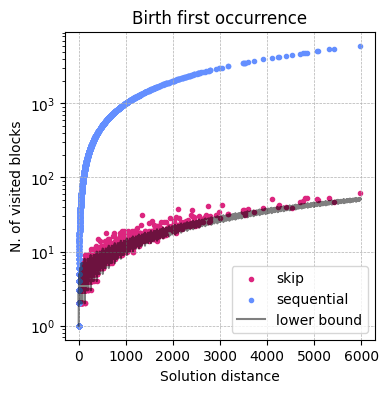

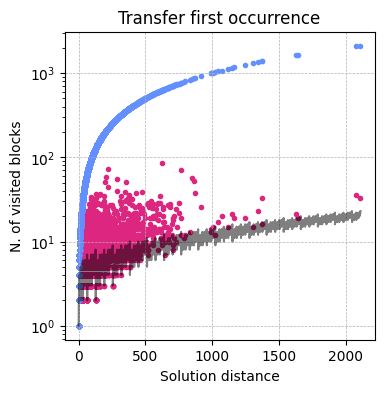

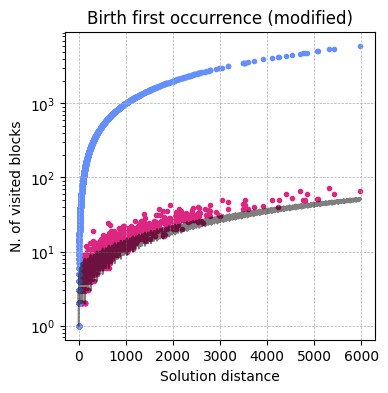

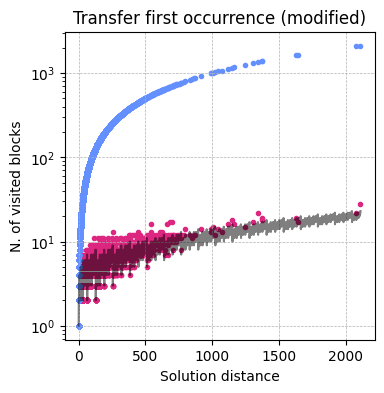

In [7]:
queryFigure(q_birth, 'Birth first occurrence', 'pictures/query_birth.pdf', True)
queryFigure(q_transfer, 'Transfer first occurrence', 'pictures/query_transfer.pdf', False)
queryFigure(q_birth_m, 'Birth first occurrence (modified)', 'pictures/query_birth_m.pdf', False)
queryFigure(q_transfer_m, 'Transfer first occurrence (modified)', 'pictures/query_transfer_m.pdf', False)